# <center>Google Analytics Customer Revenue Prediction</center>
---

![](logo.jpg)

# Contents

1. Introduction
   * 1.1 Getting data and importing libraries
   * 1.2 Auxilliary function to load json fields
   * 1.3 Snapshot on missing values
2. Exploration - Univariate Analysis
   * 2.1 Device Attributes
   * 2.2 GeoNetwork Attributes
   * 2.3 Traffic Attributes
3. Feature engineering
   * 3.1 Convert target feature to float type
   * 3.2 Impute and Review
   * 3.3 Distinguish the categorical features
   * 3.4 Label encode categorical data
   * 3.5 One-hot encode categorical data
   * 3.6 Normalize the data
4. Deep Learning using keras
   * 4.1 Packages for deep learning
   * 4.2 Setting parameters
   * 4.3 Model summary
   * 4.4 Fitting and Model metrics
   * 4.5 Predictions


# 1. Introductions: 

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

In this [competition](https://www.kaggle.com/c/google-analytics-customer-revenue-prediction), the aim is to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. The results of predictions and analysis might lead to more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data. 

As the first step, lets load the required libraries.


## 1.1 Getting data and importing libraries

In [10]:
#There are 6 files 3 for train and 3 for test.

import warnings
warnings.simplefilter("ignore")
import os
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from IPython.display import display
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
init_notebook_mode(connected=True)
pd.set_option("display.max_rows", 1000, "display.max_columns", 1000)
pd.options.mode.chained_assignment = None

## 1.2 Auxilliary function to load json fields

In [2]:
#using https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    
    return df

def plot_metrics(loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1, sharex='col', figsize=(20,7))
    ax1.plot(loss, label='Train loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    plt.xlabel('Epochs')

In [3]:
train = load_df()
test = load_df("test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [48]:
#Loading external data
train_store_1 = pd.read_csv('Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})


In [49]:
#Getting VisitId to Join with our train, test data
def get_visitid(id):
    bef_, af_ = str(x).split('.')
    return int(bef_), (int(af_)*10 if len(af_)==1 else int(af_))

for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(str)

train_exdata = pd.concat([train_store_1, train_store_2], sort=False)
test_exdata = pd.concat([test_store_1, test_store_2], sort=False)

for df in [train, test]:
    df["visitId"] = df["visitId"].astype(str)

In [50]:
# Merge with train/test data
train_new = train.merge(train_exdata, how="left", on="visitId")
test_new = test.merge(test_exdata, how="left", on="visitId")

del train
del test
train = train_new
test = test_new
del train_new
del test_new

train_backup = train.copy()
test_backup = test.copy()

### This is how our data looks like

In [8]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903654
Columns: 62
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime'
 'device.browser' 'device.browserSize' 'device.browserVersion'
 'device.deviceCategory' 'device.flashVersion' 'device.isMobile'
 'device.language' 'device.mobileDeviceBranding' 'device.mobileDeviceInfo'
 'device.mobileDeviceMarketingName' 'device.mobileDeviceModel'
 'device.mobileInputSelector' 'device.operatingSystem'
 'device.operatingSystemVersion' 'device.screenColors'
 'device.screenResolution' 'geoNetwork.city' 'geoNetwork.cityId'
 'geoNetwork.continent' 'geoNetwork.country' 'geoNetwork.latitude'
 'geoNetwork.longitude' 'geoNetwork.metro' 'geoNetwork.networkDomain'
 'geoNetwork.networkLocation' 'geoNetwork.region'
 'geoNetwork.subContinent' 'totals.bounces' 'totals.hits'
 'totals.newVisits' 'totals.pageviews' 'totals.transactionRevenue'
 'totals.visits' 'trafficSource.adContent'
 'trafficSource.adwordsClickInfo.adNetwo

## 1.3 Snapshot on missing values

Let's plot the missing values percentage for columns having missing values.

In [11]:
miss_per = {}
for k, v in dict(train.isna().sum(axis=0)).items():
    if v == 0:
        continue
    miss_per[k] = 100 * float(v) / len(train)
    
import operator
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
sorted_x = sorted(miss_per.items(), key=operator.itemgetter(1), reverse=True)
print ("There are " + str(len(miss_per)) + " columns with missing values")

kys = [_[0] for _ in sorted_x][::-1]
vls = [_[1] for _ in sorted_x][::-1]
trace1 = go.Bar(y = kys, orientation="h" , x = vls, marker=dict(color="#d6a5ff"))
layout = go.Layout(title="Missing Values Percentage", 
                   xaxis=dict(title="Missing Percentage"), 
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

There are 21 columns with missing values


# 2. Exploration - Univariate Analysis

Lets plot the distribution of device attributes.

## 2.1 Device Attributes

In [13]:
device_cols = ["device.browser", "device.deviceCategory", "device.operatingSystem"]

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(device_cols):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15][::-1], x = t.values[:15][::-1]))

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits: Category", "Visits: Browser","Visits: OS"], print_grid=False)
fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[0], 1, 2)
fig.append_trace(traces[2], 1, 3)

fig['layout'].update(height=400, showlegend=False, title="Visits by Device Attributes")
iplot(fig)

## convert transaction revenue to float
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')

device_cols = ["device.browser", "device.deviceCategory", "device.operatingSystem"]

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Mean Revenue: Category", "Mean Revenue: Browser","Mean Revenue: OS"], print_grid=False)

colors = ["red", "green", "purple"]
trs = []
for i, col in enumerate(device_cols):
    tmp = train.groupby(col).agg({"totals.transactionRevenue": "mean"}).reset_index().rename(columns={"totals.transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(x = tmp["Mean Revenue"][::-1], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col][::-1])
    trs.append(tr)

fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[0], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False, title="Mean Revenue by Device Attributes")
iplot(fig)

## 2.2 GeoNetwork Attributes

In [14]:
geo_cols = ['geoNetwork.city', 'geoNetwork.continent','geoNetwork.country',
            'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']
geo_cols = ['geoNetwork.continent','geoNetwork.subContinent']

colors = ["#d6a5ff", "#fca6da"]
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Visits : GeoNetwork Continent", "Visits : GeoNetwork subContinent"], print_grid=False)
trs = []
for i,col in enumerate(geo_cols):
    t = train[col].value_counts()
    tr = go.Bar(x = t.index[:20], marker=dict(color=colors[i]), y = t.values[:20])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=400, margin=dict(b=150), showlegend=False)
iplot(fig)




geo_cols = ['geoNetwork.continent','geoNetwork.subContinent']
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Mean Revenue: Continent", "Mean Revenue: SubContinent"], print_grid=False)

colors = ["blue", "orange"]
trs = []
for i, col in enumerate(geo_cols):
    tmp = train.groupby(col).agg({"totals.transactionRevenue": "mean"}).reset_index().rename(columns={"totals.transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(y = tmp["Mean Revenue"], orientation="v", marker=dict(opacity=0.5, color=colors[i]), x= tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=450, margin=dict(b=200), showlegend=False)
iplot(fig)

In [20]:
tmp = train["geoNetwork.country"].value_counts()

# plotly globe credits - https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals
colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = tmp.index,
        z = tmp.values,
        locationmode = 'country names',
        text = tmp.values,
        marker = dict(
            line = dict(color = '#fff', width = 2)) )           ]

layout = dict(
    height=500,
    title = 'Visits by Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)


tmp = train.groupby("geoNetwork.country").agg({"totals.transactionRevenue" : "mean"}).reset_index()



# plotly globe credits - https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals
colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = tmp["geoNetwork.country"],
        z = tmp["totals.transactionRevenue"],
        locationmode = 'country names',
        text = tmp["totals.transactionRevenue"],
        marker = dict(
            line = dict(color = '#fff', width = 2)) )           ]

layout = dict(
    height=500,
    title = 'Mean Revenue by Countries',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

## 2.3 Traffic Attributes

In [21]:
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["TrafficSource Campaign (not-set removed)", "TrafficSource Medium"], print_grid=False)

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
t1 = train["trafficSource.campaign"].value_counts()
t2 = train["trafficSource.medium"].value_counts()
tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[3]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))
tr3 = go.Bar(x = t1.index[1:], y = t1.values[1:], marker=dict(color=colors[0]))
tr4 = go.Bar(x = t2.index[1:], y = t2.values[1:])

fig.append_trace(tr3, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=400, margin=dict(b=100), showlegend=False)
iplot(fig)

In [22]:
tmp = train["channelGrouping"].value_counts()
colors = ["#8d44fc", "#ed95d5", "#caadf7", "#6161b7", "#7e7eba", "#babad1"]
trace = go.Pie(labels=tmp.index, values=tmp.values, marker=dict(colors=colors))
layout = go.Layout(title="Channel Grouping", height=400)
fig = go.Figure(data = [trace], layout = layout)
iplot(fig, filename='basic_pie_chart')

In [27]:
def _add_date_features(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    return df 

train = _add_date_features(train)

tmp = train['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)


tmp = train.groupby("date").agg({"totals.transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "totals.transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="MonthlyRevenue by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [29]:
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits by Month", "Visits by MonthDay", "Visits by WeekDay"], print_grid=False)
trs = []
for i,col in enumerate(["month", "day", "weekday"]):
    t = train[col].value_counts()
    tr = go.Bar(x = t.index, marker=dict(color=colors[i]), y = t.values)
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)



tmp1 = train.groupby('month').agg({"totals.transactionRevenue" : "mean"}).reset_index()
tmp2 = train.groupby('day').agg({"totals.transactionRevenue" : "mean"}).reset_index()
tmp3 = train.groupby('weekday').agg({"totals.transactionRevenue" : "mean"}).reset_index()

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["MeanRevenue by Month", "MeanRevenue by MonthDay", "MeanRevenue by WeekDay"], print_grid=False)
tr1 = go.Bar(x = tmp1.month, marker=dict(color="red", opacity=0.5), y = tmp1["totals.transactionRevenue"])
tr2 = go.Bar(x = tmp2.day, marker=dict(color="orange", opacity=0.5), y = tmp2["totals.transactionRevenue"])
tr3 = go.Bar(x = tmp3.weekday, marker=dict(color="green", opacity=0.5), y = tmp3["totals.transactionRevenue"])

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

In [30]:
vn = train["visitNumber"].value_counts()
def vn_bins(x):
    if x == 1:
        return "1" 
    elif x < 5:
        return "2-5"
    elif x < 10:
        return "5-10"
    elif x < 50:
        return "10-50"
    elif x < 100:
        return "50-100"
    else:
        return "100+"
    
vn = train["visitNumber"].apply(vn_bins).value_counts()

trace1 = go.Bar(y = vn.index[::-1], orientation="h" , x = vn.values[::-1], marker=dict(color="#7af9ad"))
layout = go.Layout(title="Visit Numbers Distribution", 
                   xaxis=dict(title="Frequency"),yaxis=dict(title="VisitNumber") ,
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

There are 9996 visitors in the train dataset having non zero total transaction revenue


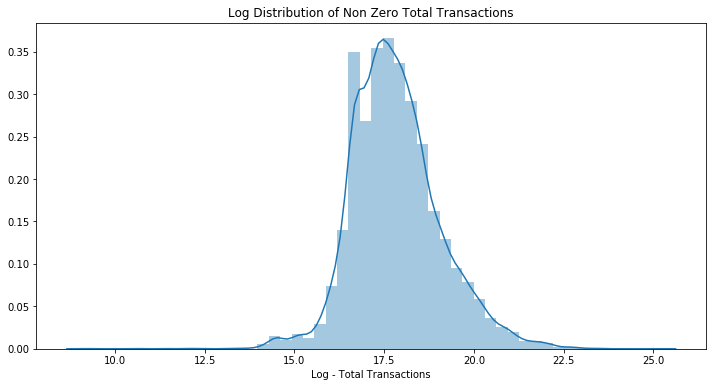

In [36]:
agg_dict = {}
for col in ["totals.bounces", "totals.hits", "totals.newVisits", "totals.pageviews", "totals.transactionRevenue"]:
    train[col] = train[col].astype('float')
    agg_dict[col] = "sum"
tmp = train.groupby("fullVisitorId").agg(agg_dict).reset_index()

non_zero = tmp[tmp["totals.transactionRevenue"] > 0]["totals.transactionRevenue"]
print ("There are " + str(len(non_zero)) + " visitors in the train dataset having non zero total transaction revenue")

plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Log Distribution of Non Zero Total Transactions");
plt.xlabel("Log - Total Transactions");

In [38]:
def getbin_hits(x):
    if x < 5:
        return "1-5"
    elif x < 10:
        return "5-10"
    elif x < 30:
        return "10-30"
    elif x < 50:
        return "30-50"
    elif x < 100:
        return "50-100"
    else:
        return "100+"

tmp["total.hits_bin"] = tmp["totals.hits"].apply(getbin_hits)
tmp["totals.bounces_bin"] = tmp["totals.bounces"].apply(lambda x : str(x) if x <= 5 else "5+")
tmp["totals.pageviews_bin"] = tmp["totals.pageviews"].apply(lambda x : str(x) if x <= 50 else "50+")

t1 = tmp["total.hits_bin"].value_counts()
t2 = tmp["totals.bounces_bin"].value_counts()
t3 = tmp["totals.newVisits"].value_counts()
t4 = tmp["totals.pageviews_bin"].value_counts()

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=["Total Hits per User", "Total Bounces per User", 
                                                         "Total NewVistits per User", "Total PageViews per User"], print_grid=False)

tr1 = go.Bar(x = t1.index[:20], y = t1.values[:20])
tr2 = go.Bar(x = t2.index[:20], y = t2.values[:20])
tr3 = go.Bar(x = t3.index[:20], y = t3.values[:20])
tr4 = go.Bar(x = t4.index, y = t4.values)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 2, 1)
fig.append_trace(tr4, 2, 2)

fig['layout'].update(height=700, showlegend=False)
iplot(fig)

# 3. Feature engineering

After the exploratory data analysis, we start to do feature engineering for keras deep learning model.

In [46]:
#dataset recover
train = train_backup.copy()
test = test_backup.copy()

In [51]:
# Drop Client Id
for df in [train, test]:
    df.drop("Client Id", 1, inplace=True)

In [52]:
#Cleaning Revenue
for df in [train, test]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

#Imputing NaN
for df in [train, test]:
    df["Sessions"] = df["Sessions"].fillna(0)
    df["Avg. Session Duration"] = df["Avg. Session Duration"].fillna(0)
    df["Bounce Rate"] = df["Bounce Rate"].fillna(0)
    df["Revenue"] = df["Revenue"].fillna(0)
    df["Transactions"] = df["Transactions"].fillna(0)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].fillna(0)
    df['trafficSource.adContent'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.slot'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.page'].fillna(0.0, inplace=True)
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.gclId'].fillna('N/A', inplace=True)
    df['trafficSource.isTrueDirect'].fillna('N/A', inplace=True)
    df['trafficSource.referralPath'].fillna('N/A', inplace=True)
    df['trafficSource.keyword'].fillna('N/A', inplace=True)
    df['totals.bounces'].fillna(0.0, inplace=True)
    df['totals.newVisits'].fillna(0.0, inplace=True)
    df['totals.pageviews'].fillna(0.0, inplace=True)
    df["Goal Conversion Rate"]=df["Goal Conversion Rate"].replace(to_replace=r'%', value=r'', regex=True).astype(float)/100
    df["Bounce Rate"]=df["Bounce Rate"].replace(to_replace=r'%', value=r'', regex=True).astype(float)/100


## 3.1 Convert target feature to float type

In [53]:
train = add_time_features(train)
test = add_time_features(test)

train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
float_features = ["totals.hits","totals.pageviews","totals.bounces","totals.newVisits"]

for df in [train,test] :
    for c in float_features :
        df[c] = df[c].astype(float)

### Agregated features

In [54]:
# Train
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train['fullVisitorId'] = gp_fullVisitorId_train.index
gp_fullVisitorId_train['mean_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.hits'].transform('mean')
gp_fullVisitorId_train['mean_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.pageviews'].transform('mean')
gp_fullVisitorId_train['sum_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.hits'].transform('sum')
gp_fullVisitorId_train['sum_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.pageviews'].transform('sum')
gp_fullVisitorId_train = gp_fullVisitorId_train[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
train = train.join(gp_fullVisitorId_train, on='fullVisitorId', how='inner', rsuffix='_')
train.drop(['fullVisitorId_'], axis=1, inplace=True)

# Test
gp_fullVisitorId_test = test.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_test['fullVisitorId'] = gp_fullVisitorId_test.index
gp_fullVisitorId_test['mean_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.hits'].transform('mean')
gp_fullVisitorId_test['mean_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.pageviews'].transform('mean')
gp_fullVisitorId_test['sum_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.hits'].transform('sum')
gp_fullVisitorId_test['sum_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.pageviews'].transform('sum')
gp_fullVisitorId_test = gp_fullVisitorId_test[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
test = test.join(gp_fullVisitorId_test, on='fullVisitorId', how='inner', rsuffix='_')
test.drop(['fullVisitorId_'], axis=1, inplace=True)

In [55]:
# Turning Avg. Session Duration into seconds
for df in [train, test]:
    ASD = df["Avg. Session Duration"]
    ASD = ASD.str.extract(r'(\d*):(\d*):(\d*)').fillna(0).astype(float)
    ASD["time"] = ASD[0]*3600+ASD[1]*60+ASD[2]
    df["Avg. Session Duration"] = ASD["time"]
    

In [56]:
# Unwanted columns
unwanted_columns = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', "date" , 
                    'device.browser', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 
                    'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 
                    'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.operatingSystem',
                    'geoNetwork.metro','geoNetwork.networkDomain', 'geoNetwork.networkLocation', 'trafficSource.adContent', 'trafficSource.campaign', 
                    'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.source','day']

test_ids = test["fullVisitorId"]
train.drop('trafficSource.campaignCode', 1, inplace=True)

train=train.drop(unwanted_columns, axis=1)
test=test.drop(unwanted_columns, axis=1)


# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)

train=train.drop(constant_columns, axis=1)
test=test.drop(constant_columns, axis=1)

# Columns with more than 50% null data
#high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
#print('Columns more than 50% null values: ', high_null_columns)
#train = train.drop(high_null_columns, axis=1)
#test = test.drop(high_null_columns, axis=1)



Columns with constant values:  ['socialEngagementType', 'device.language', 'device.mobileDeviceBranding', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters']


## 3.2 Impute and Review

In [57]:
train['totals.transactionRevenue'].fillna(0, inplace=True)
y_train = train['totals.transactionRevenue']
train = train.drop(['totals.transactionRevenue'], axis=1)


In [58]:
print(train.shape)
print(y_train.shape)
print(test.shape)
print(test_ids.shape)

(903654, 32)
(903654,)
(804686, 32)
(804686,)


In [59]:
train.head()

,channelGrouping,visitNumber,device.deviceCategory,device.isMobile,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.medium,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,year,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,1,desktop,False,Izmir,Asia,Turkey,Izmir,Western Asia,1.0,1.0,1.0,1.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2016,9,4,3.943076,3.371298,83747.0,71603.0
1,Organic Search,1,desktop,False,not available in demo dataset,Oceania,Australia,not available in demo dataset,Australasia,1.0,1.0,1.0,1.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2016,9,4,3.943076,3.371298,83747.0,71603.0
2,Organic Search,1,desktop,False,Madrid,Europe,Spain,Community of Madrid,Southern Europe,1.0,1.0,1.0,1.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2016,9,4,3.943076,3.371298,83747.0,71603.0
3,Organic Search,1,desktop,False,not available in demo dataset,Asia,Indonesia,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2016,9,4,3.943076,3.371298,83747.0,71603.0
4,Organic Search,2,mobile,True,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,Northern Europe,1.0,1.0,0.0,1.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2016,9,4,4.324027,3.666491,90290.0,76560.0


In [60]:
test.head()

,channelGrouping,visitNumber,device.deviceCategory,device.isMobile,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.medium,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,year,month,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2,desktop,False,(not set),Asia,Singapore,(not set),Southeast Asia,0.0,4.0,0.0,4.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2017,10,0,11.151546,9.170299,22002.0,18093.0
289310,Organic Search,1,desktop,False,(not set),Asia,Singapore,(not set),Southeast Asia,0.0,4.0,1.0,4.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2017,9,0,11.151546,9.170299,22002.0,18093.0
1,Organic Search,1,desktop,False,Zaragoza,Europe,Spain,Aragon,Southern Europe,0.0,5.0,1.0,5.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2017,10,0,4.087874,3.427959,76292.0,63976.0
2,Organic Search,1,desktop,False,not available in demo dataset,Europe,France,not available in demo dataset,Western Europe,0.0,7.0,1.0,7.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2017,10,0,4.087874,3.427959,76292.0,63976.0
3,Organic Search,1,mobile,True,Mountain View,Americas,United States,California,Northern America,0.0,8.0,1.0,4.0,N/A,N/A,N/A,0,N/A,organic,0.0,0.0,0.0,0.0,0.0,0.0,2017,10,0,4.087874,3.427959,76292.0,63976.0


## 3.3 Distinguish the categorical features

In [61]:
categorical_features = train.select_dtypes(exclude=['number']).columns.values
Below10_columns = [c for c in train.columns if train[c].nunique()<=10 and train[c].nunique()>=1]

Below10unique_categorical_features = np.intersect1d(categorical_features,Below10_columns)
Above10unique_categorical_features = [c for c in categorical_features if c not in Below10unique_categorical_features]

In [62]:
print(categorical_features)

print(Below10unique_categorical_features)
print(Above10unique_categorical_features)

['channelGrouping' 'device.deviceCategory' 'device.isMobile'
 'geoNetwork.city' 'geoNetwork.continent' 'geoNetwork.country'
 'geoNetwork.region' 'geoNetwork.subContinent'
 'trafficSource.adwordsClickInfo.adNetworkType'
 'trafficSource.adwordsClickInfo.gclId'
 'trafficSource.adwordsClickInfo.isVideoAd'
 'trafficSource.adwordsClickInfo.page'
 'trafficSource.adwordsClickInfo.slot' 'trafficSource.medium']
['channelGrouping' 'device.deviceCategory' 'device.isMobile'
 'geoNetwork.continent' 'trafficSource.adwordsClickInfo.adNetworkType'
 'trafficSource.adwordsClickInfo.isVideoAd'
 'trafficSource.adwordsClickInfo.page'
 'trafficSource.adwordsClickInfo.slot' 'trafficSource.medium']
['geoNetwork.city', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adwordsClickInfo.gclId']


## 3.4 Label encode categorical data

In [63]:
for f in Above10unique_categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])


## 3.5 One-hot encode categorical data

In [64]:
train = pd.get_dummies(train, columns=Below10unique_categorical_features)
test = pd.get_dummies(test, columns=Below10unique_categorical_features)

In [65]:
# align both data sets (by outer join), to make they have the same amount of features,
# this is required because of the mismatched categorical values in train and test sets
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

## 3.6 Normalize the data

In [66]:
# Log transform the labels
y_train_log = np.log1p(y_train)

normalized_features = ['visitNumber', 'totals.hits', 'totals.pageviews', 
                       'mean_hits_per_day', 'mean_pageviews_per_day', 
                       'sum_hits_per_day', 'sum_pageviews_per_day']

# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
train[normalized_features] = scaler.fit_transform(train[normalized_features])
test[normalized_features] = scaler.transform(test[normalized_features])

# 4. Deep Learning using keras

## 4.1 Packages for deep learning

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

%matplotlib inline
pd.options.display.max_columns = 999

Using TensorFlow backend.


## 4.2 Setting parameters

In [68]:
BATCH_SIZE = 30
EPOCHS = 100
LEARNING_RATE = 0.0003

In [69]:
model = Sequential()
model.add(Dense(1024, kernel_initializer='glorot_normal', activation='relu', input_dim=train.shape[1]))
model.add(Dense(512, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

In [70]:
adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

## 4.3 Model summary

In [71]:
print('Dataset size: %s' % train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % train.shape[1])
print('Features used: %s' % train.columns.values)

Dataset size: 903654
Epochs: 100
Learning rate: 0.0003
Batch size: 30
Input dimension: 71
Features used: ['Avg. Session Duration' 'Bounce Rate' 'Goal Conversion Rate' 'Revenue'
 'Sessions' 'Transactions' 'channelGrouping_(Other)'
 'channelGrouping_Affiliates' 'channelGrouping_Direct'
 'channelGrouping_Display' 'channelGrouping_Organic Search'
 'channelGrouping_Paid Search' 'channelGrouping_Referral'
 'channelGrouping_Social' 'device.deviceCategory_desktop'
 'device.deviceCategory_mobile' 'device.deviceCategory_tablet'
 'device.isMobile_False' 'device.isMobile_True' 'geoNetwork.city'
 'geoNetwork.continent_(not set)' 'geoNetwork.continent_Africa'
 'geoNetwork.continent_Americas' 'geoNetwork.continent_Asia'
 'geoNetwork.continent_Europe' 'geoNetwork.continent_Oceania'
 'geoNetwork.country' 'geoNetwork.region' 'geoNetwork.subContinent'
 'mean_hits_per_day' 'mean_pageviews_per_day' 'month' 'sum_hits_per_day'
 'sum_pageviews_per_day' 'totals.bounces' 'totals.hits' 'totals.newVisits'
 'total

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              73728     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 599,041
Trainable params: 599,041
Non-trainable params: 0
_________________________________________________________________


## 4.4 Fitting and Model metrics

In [73]:
%%time
history = model.fit(x=train, y=y_train_log, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1,validation_split=0.1) #validation_data=(X_val.values, Y_val))

Train on 813288 samples, validate on 90366 samples
Epoch 1/100
 58020/813288 [=>............................] - ETA: 2:06 - loss: 697.0400

KeyboardInterrupt: 

In [55]:
val_predictions = model.predict(train)
mse = mean_squared_error(val_predictions, y_train_log)
rmse = np.sqrt(mean_squared_error(val_predictions, y_train_log))

print('Model validation metrics')
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)

Model validation metrics
MSE: 3.11
RMSE: 1.76


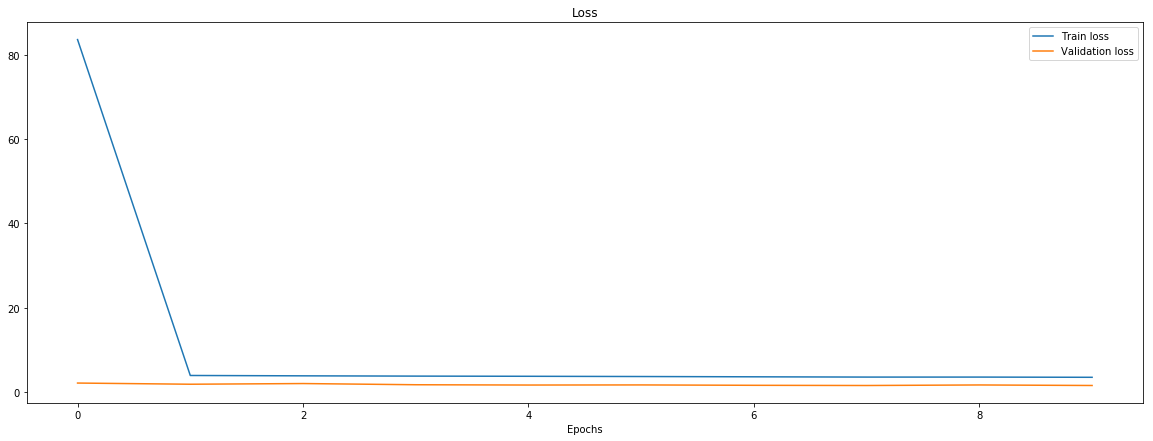

In [56]:
plot_metrics(history.history['loss'], history.history['val_loss'])

## 4.5 Predictions

In [57]:
predictions = model.predict(test)

submission = pd.DataFrame({"fullVisitorId":test_ids})
test["PredictedLogRevenue"] = np.expm1(predictions)
submission = test.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] =  submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission.to_csv("submission_20181019_03.csv", index=False)